In [1]:
#Resnet50 
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Activation, Input, Dense, SeparableConv2D
from keras.models import Model
from keras.regularizers import l2

In [2]:
import keras
import numpy as np

# initializer =  keras.initializers.glorot_uniform(seed=0)
initializer = keras.initializers.glorot_normal()

"""
Creates Residual Network with 50 layers
"""
def resnet_model(input_shape, classes):
    # Define the input as a tensor with shape input_shape
    X_input = keras.layers.Input(input_shape)

    # Zero-Padding
    X = keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', 
                            kernel_initializer=initializer)(X)
    X = keras.layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    X = convolutional_block(X, f = 3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = keras.layers.AveragePooling2D(pool_size=(2, 2))(X)
    
    # output layer
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(classes, activation='softmax', name='fc{}'
                            .format(classes), kernel_initializer=initializer)(X)
    
    # Create model
    model = keras.models.Model(inputs=X_input, outputs=X)

    return model

"""
Identity Block of ResNet
"""
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = keras.layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1,1), padding='valid', 
                            name=conv_name_base + '2a', kernel_initializer=initializer)(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    
    # Second component of main path
    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1,1), padding='same', 
                            name=conv_name_base + '2b', kernel_initializer=initializer)(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.5)(X)

    # Third component of main path
    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1,1), padding='valid', 
                            name=conv_name_base + '2c', kernel_initializer=initializer)(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)
    
    return X

"""
Convolutional Block of ResNet
"""
def convolutional_block(X, f, filters, stage, block, s=2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = keras.layers.Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', 
                            padding='valid', kernel_initializer=initializer)(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.5)(X)
    
    # Second component of main path
    X = keras.layers.Conv2D(F2, (f, f), strides=(1, 1), name=conv_name_base + '2b', 
                            padding='same', kernel_initializer=initializer)(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.5)(X)

    # Third component of main path
    X = keras.layers.Conv2D(F3, (1, 1), strides=(1, 1), name=conv_name_base + '2c', 
                            padding='valid', kernel_initializer=initializer)(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv2D(F3, (1, 1), strides=(s,s), name=conv_name_base + '1', 
                                    padding='valid', kernel_initializer=initializer)(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
input_shape = (229, 229, 3)
num_classes = 7
resnet_model(input_shape, num_classes).summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 235, 235, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 115, 115, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 115, 115, 64) 256         conv1[0][0]                      
______________________________________________________________________________________________

In [3]:
# Training
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.optimizers import SGD
from keras import backend as K

In [4]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainset_dir = r"/content/drive/MyDrive/Dataset/Dataset_Shuffled/Train"
valset_dir = r"/content/drive/MyDrive/Dataset/Dataset_Shuffled/Validation"

In [ ]:
num_classes = 7
learning_rate = 1e-3
batch_size = 8
input_shape = (229, 229, 3)
momentum = 0.9

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    trainset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size)

val_generator = val_datagen.flow_from_directory(
    valset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    shuffle=False)

Found 2672 images belonging to 7 classes.
Found 532 images belonging to 7 classes.


In [ ]:
K.clear_session()

In [ ]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [ ]:
optim = SGD(lr=learning_rate, momentum=momentum)

In [ ]:
model = resnet_model(input_shape, num_classes)

In [ ]:
model.compile(optimizer=optim, loss='categorical_crossentropy',
              metrics=[precision,recall,'accuracy'])

In [ ]:
csv_path = r"/content/drive/MyDrive/ResNet50/result_show/resnet_model.csv"
log_dir = r"/content/drive/MyDrive/ResNet50/result_show/resnet_model"
save_weights_path = r"/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-{epoch:02d}-val_loss-{val_loss:.4f}-val_acc-{val_accuracy:.4f}.h5"

In [ ]:
checkpoint = ModelCheckpoint(save_weights_path, monitor='val_accuracy', verbose=1, 
                             save_weights_only=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1, min_lr=1e-4)

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=25, verbose=1)

In [ ]:
logging = TensorBoard(log_dir=log_dir)
csvlogger = CSVLogger(csv_path, append=True)
callbacks = [checkpoint, reduce_lr, logging, csvlogger]

In [ ]:
num_epochs = 500

In [ ]:
model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=num_epochs,
          verbose=1, 
          callbacks=callbacks, 
          validation_data=val_generator, 
          validation_steps=len(val_generator),
          workers = 1)

Epoch 1/500
334/334 [==============================] - 647s 2s/step - loss: 14.9465 - precision: 0.1650 - recall: 0.1519 - accuracy: 0.1645 - val_loss: 6.2489 - val_precision: 0.1437 - val_recall: 0.1437 - val_accuracy: 0.1447

Epoch 00001: val_accuracy improved from -inf to 0.14474, saving model to /content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-01-val_loss-6.2489-val_acc-0.1447.h5
Epoch 2/500
334/334 [==============================] - 56s 169ms/step - loss: 5.1186 - precision: 0.2250 - recall: 0.1684 - accuracy: 0.2065 - val_loss: 3.2612 - val_precision: 0.0697 - val_recall: 0.0168 - val_accuracy: 0.2049

Epoch 00002: val_accuracy improved from 0.14474 to 0.20489, saving model to /content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-02-val_loss-3.2612-val_acc-0.2049.h5
Epoch 3/500
334/334 [==============================] - 57s 169ms/step - loss: 3.8237 - precision: 0.1963 - recall: 0.1053 - accuracy: 0.1649 - val_loss: 2.8398 - val_precision: 0.0896 - val_recall

In [5]:
#Testing
import numpy as np 
import tensorflow as tf 
import seaborn as sn
from matplotlib import pyplot as plt 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os

path = r"/content/drive/MyDrive/ResNet50/weights"
input_shape = (229, 229, 3)
num_classes = 7
testset_dir = r"/content/drive/MyDrive/Dataset/Dataset_Shuffled/Testing"
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    testset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=140 , # The number of test images
    class_mode='categorical')
x_test, y_test = test_generator.__getitem__(0)
for file in os.listdir(path):
  try:
    filepath = os.path.join(path,file)
    model = resnet_model(input_shape, num_classes)
    model.load_weights(filepath)
    # Prediction on test set
    y_pred = model.predict(x_test)
    acc = np.count_nonzero(np.equal(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))/x_test.shape[0]
    print(filepath)
    print(acc)# Test set accuracy
  except:
    pass

Found 140 images belonging to 7 classes.
/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-48-val_loss-1.0812-val_acc-0.6090.h5
0.6571428571428571
/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-63-val_loss-1.2272-val_acc-0.6541.h5
0.7071428571428572
/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-68-val_loss-0.9152-val_acc-0.6861.h5
0.7357142857142858
/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-71-val_loss-0.9569-val_acc-0.6898.h5
0.7071428571428572
/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-77-val_loss-0.8398-val_acc-0.7030.h5
0.75
/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-93-val_loss-0.8250-val_acc-0.7143.h5
0.7785714285714286
/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-101-val_loss-0.7958-val_acc-0.7293.h5
0.75
/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-105-val_loss-0.7645-val_acc-0.7406.h5
0.7928571428571428
/content/drive/MyDrive/ResNet50/weights/t

In [6]:
input_shape = (229, 229, 3)
num_classes = 7
testset_dir = r"/content/drive/MyDrive/Dataset/Dataset_Shuffled/Testing"
weight_path =  r"/content/drive/MyDrive/ResNet50/weights/trash-model-weight-ep-458-val_loss-0.5194-val_acc-0.8553.h5"
model = resnet_model(input_shape, num_classes)
model.load_weights(weight_path)

In [7]:
# Prediction on test set
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    testset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=140 , # The number of test images
    class_mode='categorical')

Found 140 images belonging to 7 classes.


In [8]:
x_test, y_test = test_generator.__getitem__(0)

In [9]:
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(x_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))
print(classification_report(test_true, test_pred))

CNN Model Accuracy on test set: 0.8500
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       1.00      1.00      1.00        18
           2       0.81      0.62      0.70        21
           3       0.79      0.65      0.71        17
           4       0.88      0.96      0.92        24
           5       0.85      0.85      0.85        20
           6       0.76      0.96      0.85        23

    accuracy                           0.85       140
   macro avg       0.85      0.84      0.84       140
weighted avg       0.85      0.85      0.85       140



In [10]:
y_pred = model.predict(x_test)
acc = np.count_nonzero(np.equal(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))/x_test.shape[0]
print(acc)# Test set accuracy

0.85


findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


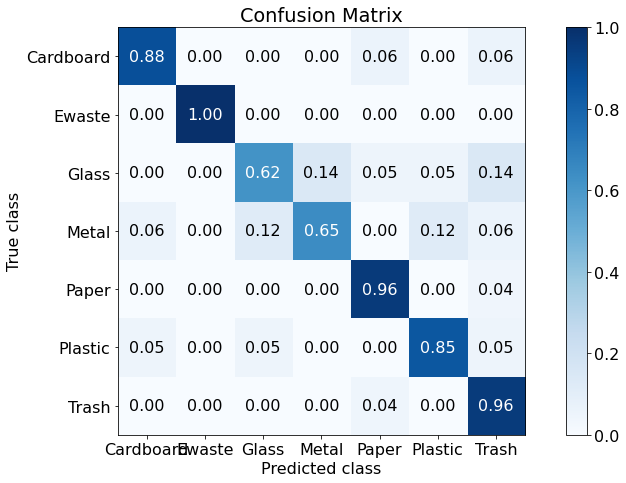

In [11]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(test_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=(12,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True class',
           xlabel='Predicted class')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, 
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plt.rc('font', family='SimHei', size=16)

classes = ['Cardboard', 'Ewaste', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=classes, normalize=True, title='Confusion Matrix')
plt.show()

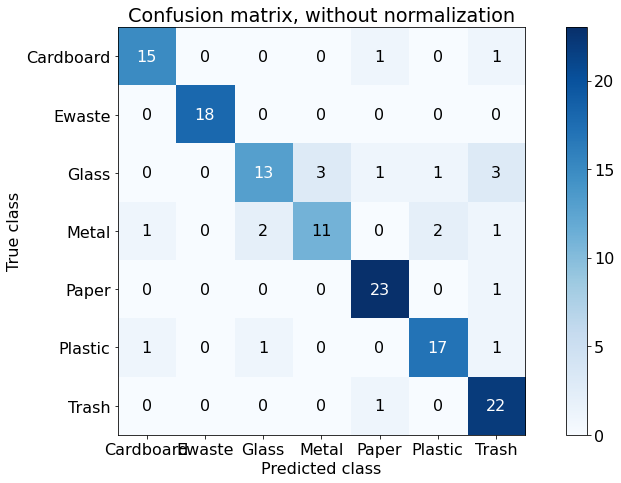

In [12]:
plot_confusion_matrix(test_true, test_pred, classes=classes, normalize=False)
plt.show()

In [13]:
print(classification_report(test_true, test_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        17
           1       1.00      1.00      1.00        18
           2       0.81      0.62      0.70        21
           3       0.79      0.65      0.71        17
           4       0.88      0.96      0.92        24
           5       0.85      0.85      0.85        20
           6       0.76      0.96      0.85        23

    accuracy                           0.85       140
   macro avg       0.85      0.84      0.84       140
weighted avg       0.85      0.85      0.85       140



In [14]:
from sklearn.metrics import confusion_matrix

predictions_one_hot = model.predict(x_test)
cm = confusion_matrix(test_true, test_pred)
print(cm)

[[15  0  0  0  1  0  1]
 [ 0 18  0  0  0  0  0]
 [ 0  0 13  3  1  1  3]
 [ 1  0  2 11  0  2  1]
 [ 0  0  0  0 23  0  1]
 [ 1  0  1  0  0 17  1]
 [ 0  0  0  0  1  0 22]]


In [15]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

Fscore = 2*(1/((1/PPV)+(1/TPR)))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TPR)
print(TNR)
print(PPV)
print(NPV)
print(FNR)
print(FDR)
print(Fscore)
print(ACC)

[0.88235294 1.         0.61904762 0.64705882 0.95833333 0.85
 0.95652174]
[0.98373984 1.         0.97478992 0.97560976 0.97413793 0.975
 0.94017094]
[0.88235294 1.         0.8125     0.78571429 0.88461538 0.85
 0.75862069]
[0.98373984 1.         0.93548387 0.95238095 0.99122807 0.975
 0.99099099]
[0.11764706 0.         0.38095238 0.35294118 0.04166667 0.15
 0.04347826]
[0.11764706 0.         0.1875     0.21428571 0.11538462 0.15
 0.24137931]
[0.88235294 1.         0.7027027  0.70967742 0.92       0.85
 0.84615385]
[0.97142857 1.         0.92142857 0.93571429 0.97142857 0.95714286
 0.94285714]


Text(0, 0.5, 'Normalized percentage')

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


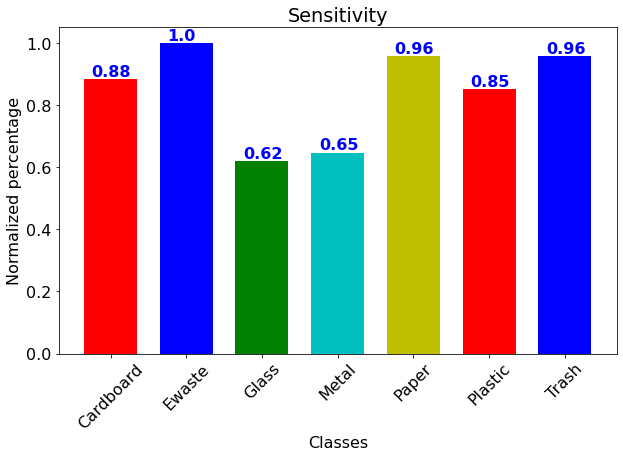

In [16]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, TPR, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(TPR):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Sensitivity')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [17]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='Sensitivity', x=classes, y=TPR,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='Sensitivity')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

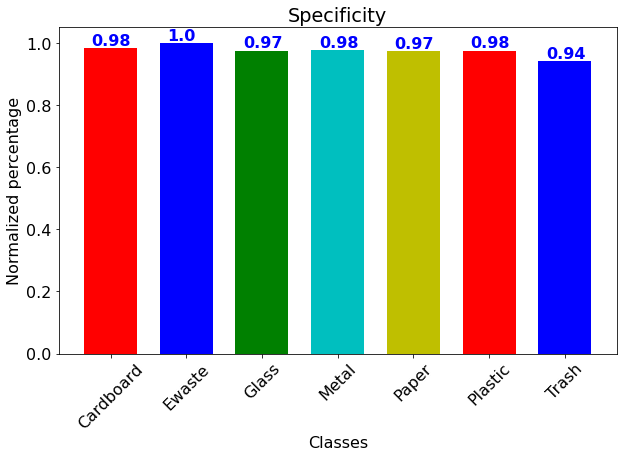

In [18]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, TNR, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(TNR):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Specificity')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [19]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='Specificity', x=classes, y=TNR,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='Specificity')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

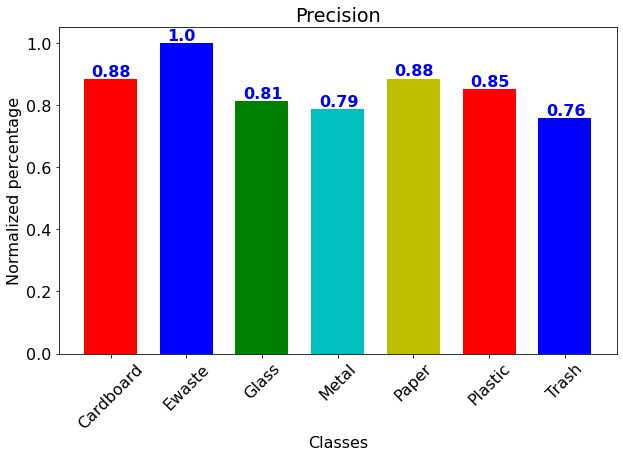

In [20]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, PPV, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(PPV):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Precision')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [21]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='Precision', x=classes, y=PPV,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='Precision')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

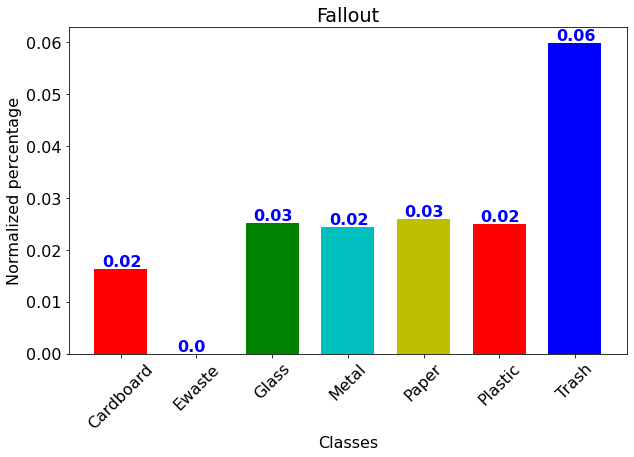

In [22]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, FPR, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(FPR):
    plt.text(i - 0.25, v + 0.0005, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Fallout')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [23]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='FallOut', x=classes, y=FPR,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='FallOut')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

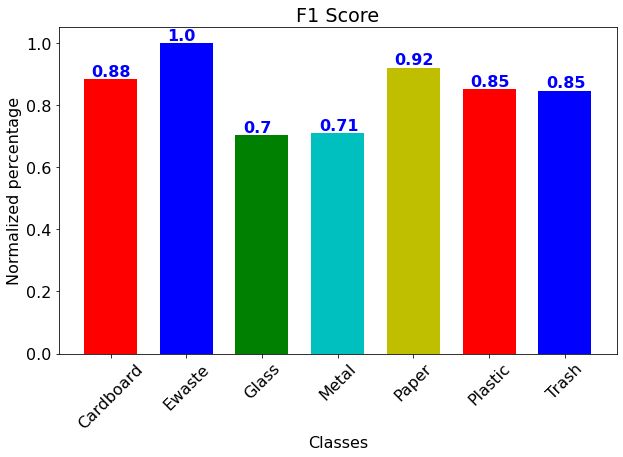

In [24]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, Fscore, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(Fscore):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('F1 Score')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [25]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='F1 Score', x=classes, y=Fscore,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='F1 Score')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

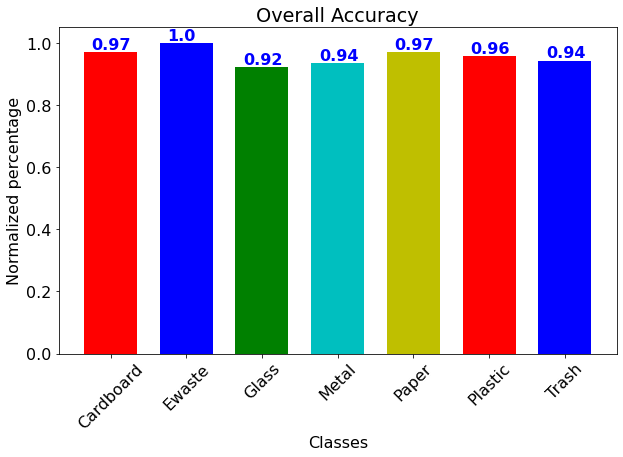

In [26]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, ACC, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(ACC):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Overall Accuracy')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [27]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=classes, y=ACC,marker_color = colors),
    
])
# Change the bar mode
fig.update_layout(title_text='Accuracy')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

In [28]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=classes, y=ACC),
    go.Bar(name='Precision', x=classes, y=PPV),
    go.Bar(name='Recall', x=classes, y=TPR)
])
# Change the bar mode
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=10)
fig.update_layout(barmode='group')
fig.show()

In [29]:
import plotly.graph_objects as px 
import numpy 
  
x = classes
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = ACC, 
    stackgroup='one',
    text = ACC,
    mode="lines+markers+text"
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'F1 Score', 
    x = x, 
    y = Fscore, 
    stackgroup='two',
    text = Fscore,
    mode="lines+markers+text"
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = PPV, 
    stackgroup='three',
    text = PPV,
    mode="lines+markers+text"
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Classes")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [30]:
def kappa_cal(matrix):
    n = np.sum(matrix)
    sum_po = 0
    sum_pe = 0
    for i in range(len(matrix[0])):
        sum_po += matrix[i][i]
        row = np.sum(matrix[i, :])
        col = np.sum(matrix[:, i])
        sum_pe += row * col
    po = sum_po / n
    pe = sum_pe / (n * n)
    # print(po, pe)
    return (po - pe) / (1 - pe)

kappa = kappa_cal(cm)
print(kappa)

0.824183710082526


In [31]:
from sklearn.metrics import cohen_kappa_score
# Kappa coefficient is a model evaluation parameter based on the calculation of the confusion matrix (the closer to 1 the better)
kappa = cohen_kappa_score(np.array(test_true).reshape(-1,1), np.array(test_pred).reshape(-1,1))
print(kappa)

0.824183710082526


In [32]:
from sklearn.metrics import hamming_loss
# Hamming distance (the closer to 0 the better)
ham_distance = hamming_loss(np.array(test_true).reshape(-1,1),np.array(test_pred).reshape(-1,1))
print(ham_distance)

0.15


In [33]:
from sklearn.metrics import jaccard_similarity_score
# Jackard's similarity coefficient (the closer to 1, the better)
# normalize is true by default. This is to calculate the average of the similarity coefficients of multiple categories. When normalize = false, the similarity coefficients of each category are calculated separately
jaccrd_score = jaccard_similarity_score(np.array(test_true).reshape(-1,1),np.array(test_pred).reshape(-1,1),normalize = True)
print(jaccrd_score)

0.85


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning:

jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.



In [34]:
from sklearn.metrics import matthews_corrcoef
matcoeff = matthews_corrcoef(test_true,test_pred)
print(matcoeff)

0.8260180472321834


In [35]:
# Print accurancy curve and loss curve
import csv
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator

In [36]:
loss = []
val_loss = []
acc = []
val_acc = []

In [37]:
with open(r"/content/drive/MyDrive/ResNet50/result_show/resnet_model.csv",'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        loss.append(float(row['loss']))
        val_loss.append(float(row['val_loss']))
        acc.append(float(row['accuracy']))
        val_acc.append(float(row['val_accuracy']))

In [38]:
epochs = range(1, len(loss) + 1)

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


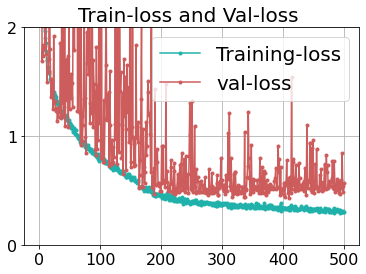

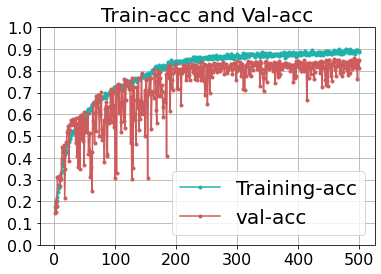

In [39]:
plt.ylim([0,2])
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(epochs, loss, 'lightseagreen', label='Training-loss', marker='.', linestyle='-')
plt.plot(epochs, val_loss, 'indianred', label='val-loss', marker='.', linestyle='-')
plt.title('Train-loss and Val-loss ', fontsize=20)
plt.legend(fontsize=20)
plt.grid()


plt.figure()
plt.ylim([0,1])
y_major_locator=MultipleLocator(0.1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(epochs, acc, 'lightseagreen', label='Training-acc', marker='.', linestyle='-')
plt.plot(epochs, val_acc, 'indianred', label='val-acc', marker='.', linestyle='-')
plt.title('Train-acc and Val-acc', fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [40]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Training Accuracy', 
    x = x, 
    y = acc, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Validation Accuracy', 
    x = x, 
    y = val_acc, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [41]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Training Loss', 
    x = x, 
    y = loss, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Validation Loss', 
    x = x, 
    y = val_loss, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [42]:
recall = []
precision = []
val_recall = []
val_precision = []

In [43]:
with open(r"/content/drive/MyDrive/ResNet50/result_show/resnet_model.csv",'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        recall.append(float(row['recall']))
        val_recall.append(float(row['val_recall']))
        precision.append(float(row['precision']))
        val_precision.append(float(row['val_precision']))

In [44]:
epochs = range(1, len(loss) + 1)

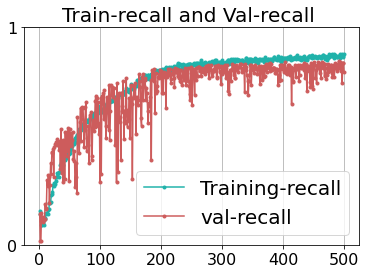

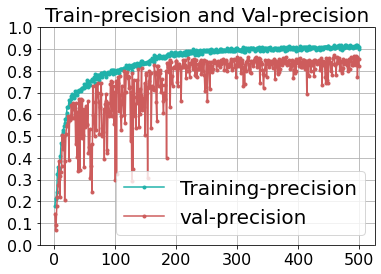

In [45]:
plt.ylim([0,1])
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(epochs, recall, 'lightseagreen', label='Training-recall', marker='.', linestyle='-')
plt.plot(epochs, val_recall, 'indianred', label='val-recall', marker='.', linestyle='-')
plt.title('Train-recall and Val-recall ', fontsize=20)
plt.legend(fontsize=20)
plt.grid()


plt.figure()
plt.ylim([0,1])
y_major_locator=MultipleLocator(0.1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(epochs, precision, 'lightseagreen', label='Training-precision', marker='.', linestyle='-')
plt.plot(epochs, val_precision, 'indianred', label='val-precision', marker='.', linestyle='-')
plt.title('Train-precision and Val-precision', fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [46]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Training Recall', 
    x = x, 
    y = recall, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Validation Recall', 
    x = x, 
    y = val_recall, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [47]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Training Precision', 
    x = x, 
    y = precision, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Validation Precision', 
    x = x, 
    y = val_precision, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [48]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = acc, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Recall', 
    x = x, 
    y = recall, 
    stackgroup='two',
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = precision, 
    stackgroup='three',
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [49]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Accuracy', 
    x = x, 
    y = val_acc, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Recall', 
    x = x, 
    y = val_recall, 
    stackgroup='two',
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Val_Precision', 
    x = x, 
    y = val_precision, 
    stackgroup='three',
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [50]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = acc, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Accuracy', 
    x = x, 
    y = val_acc, 
    stackgroup='two',
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [51]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Recall', 
    x = x, 
    y = recall, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Recall', 
    x = x, 
    y = val_recall, 
    stackgroup='two',
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [52]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = precision, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Precision', 
    x = x, 
    y = val_precision, 
    stackgroup='two',
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [53]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = acc, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Accuracy', 
    x = x, 
    y = val_acc, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [54]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Recall', 
    x = x, 
    y = recall, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Recall', 
    x = x, 
    y = val_recall, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [55]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = precision, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Precision', 
    x = x, 
    y = val_precision, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [56]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = acc, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Recall', 
    x = x, 
    y = recall, 
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = precision, 
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [57]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Accuracy', 
    x = x, 
    y = val_acc, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Recall', 
    x = x, 
    y = val_recall, 
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Val_Precision', 
    x = x, 
    y = val_precision, 
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()